In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

"""
Single head = one way to relate words
Multiple heads = different perspectives simultaneously

Example for "The cat sat on the mat":
- Head 1: syntax (subject-verb relationships)
- Head 2: semantics (meaning similarities)  
- Head 3: position (nearby words)

Each head specializes in different patterns.
"""

print("✅ Concept loaded")

✅ Concept loaded


In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Projections for all heads at once
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def split_heads(self, x):
        batch, seq_len, d_model = x.size()
        x = x.view(batch, seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 2)  # [batch, heads, seq_len, d_k]
    
    def combine_heads(self, x):
        batch, heads, seq_len, d_k = x.size()
        x = x.transpose(1, 2)
        return x.contiguous().view(batch, seq_len, self.d_model)
    
    def forward(self, x):
        # Project
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Split into heads
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # Attention for each head
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        
        # Combine heads
        output = self.combine_heads(output)
        output = self.W_o(output)
        
        return output, attention_weights

# Test
d_model = 512
num_heads = 8
x = torch.randn(2, 10, d_model)

mha = MultiHeadAttention(d_model, num_heads)
output, weights = mha(x)

print(f"Input: {x.shape}")
print(f"Output: {output.shape}")
print(f"Weights: {weights.shape}")
print(f"Heads: {num_heads}, d_k per head: {mha.d_k}")
print("✅ Multi-head attention working")

Input: torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
Weights: torch.Size([2, 8, 10, 10])
Heads: 8, d_k per head: 64
✅ Multi-head attention working


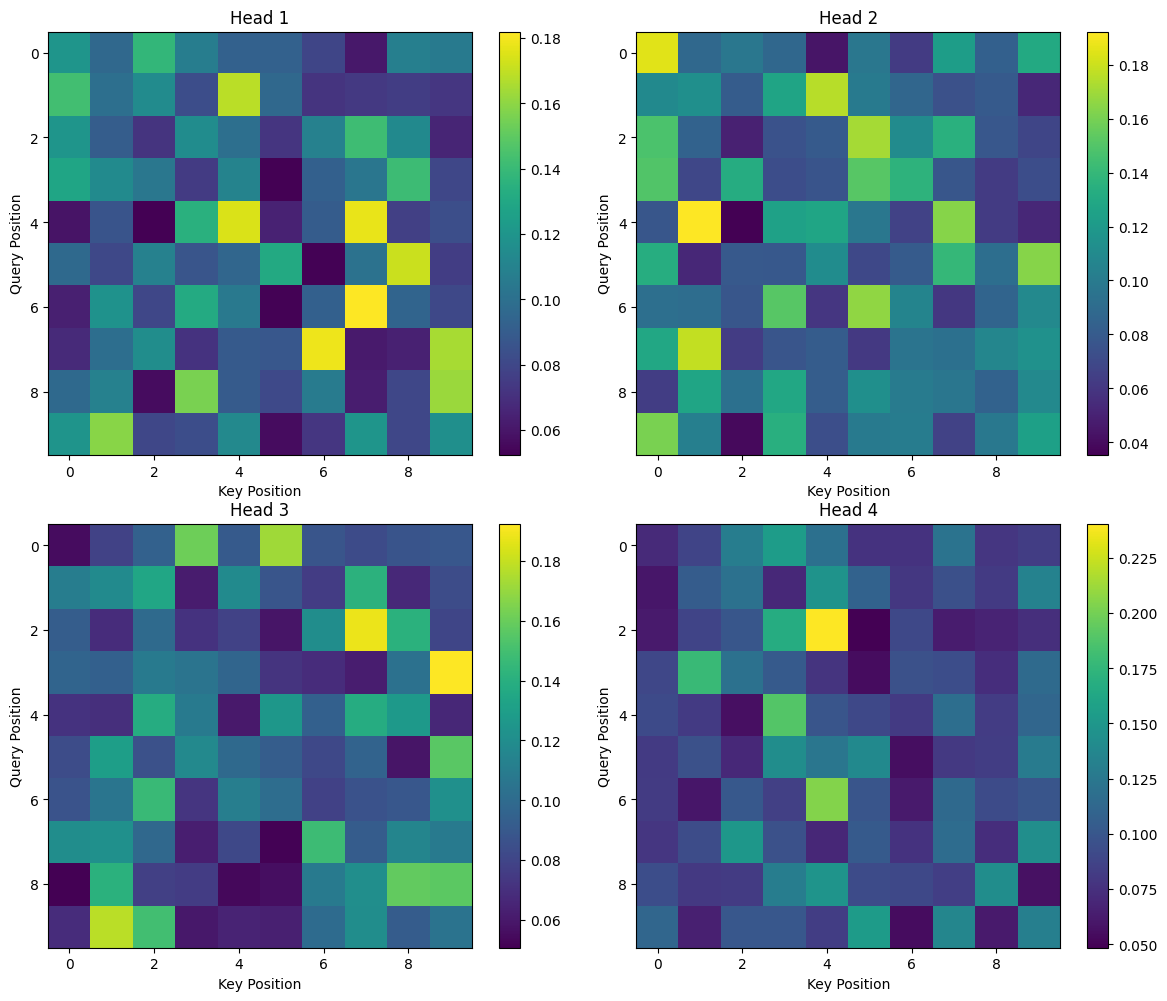

✅ Visualization saved
Notice: Each head has DIFFERENT patterns


In [3]:
# See what different heads learn
seq_len = 10
single_input = torch.randn(1, seq_len, d_model)
_, attention_weights = mha(single_input)

# Plot first 4 heads
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    weights_i = attention_weights[0, i].detach().numpy()
    im = ax.imshow(weights_i, cmap='viridis')
    ax.set_title(f'Head {i+1}')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('multihead_patterns.png')
plt.show()

print("✅ Visualization saved")
print("Notice: Each head has DIFFERENT patterns")

In [4]:
# Single head with same total parameters
class SingleHeadBaseline(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.d_model = d_model
    
    def forward(self, x):
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        weights = F.softmax(scores, dim=-1)
        return torch.matmul(weights, V)

single = SingleHeadBaseline(d_model)
multi = MultiHeadAttention(d_model, num_heads)

single_params = sum(p.numel() for p in single.parameters())
multi_params = sum(p.numel() for p in multi.parameters())

print(f"Single head params: {single_params:,}")
print(f"Multi-head params: {multi_params:,}")
print(f"Ratio: {multi_params/single_params:.2f}x")
print("\n✅ Multi-head has MORE expressiveness with similar parameters!")

Single head params: 787,968
Multi-head params: 1,050,624
Ratio: 1.33x

✅ Multi-head has MORE expressiveness with similar parameters!
